# Imports

In [1]:
import pandas as pd 
import json
import os
import numpy as np
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import punkt
import nltk
from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import recall_score, accuracy_score, confusion_matrix
import string
from nltk.probability import FreqDist
import seaborn as sns
pd.options.display.max_rows = 999
pd.options.display.max_columns = 30
import lexnlp as lnlp
import importlib
import src
from src import *
importlib.reload(src)
%matplotlib inline

# Going from JSON Files to a Useable DataFrame

Here I'm just checking out the case to see what it looks like and making sure I have a good grasp of the file path.

In [37]:
f = open('../data/supreme-court-cases/cases/1956/Achilli_v._United_States.js')
# it goes data, the repo, cases, year, then the name of the case
data = json.load(f)

## Making a List of the File Paths for each Case

Now Im going to loop through all the cases and append each ones name to the file path that will give me access to it. 

In [3]:
# adding the years as the second level
ls_years = []
for x in range(1956, 2018):
    ls_years.append(x)
file_paths = []
for x in ls_years:
    file_paths.append(f'../data/supreme-court-cases/cases/{x}')

In [4]:
#making the list of case names
cases = {} 
for x in range(0, len(ls_years)):
    json_files = [pos_json for pos_json in os.listdir(file_paths[x]) if pos_json.endswith('.js')]
    cases.update({ls_years[x]: json_files})


In [5]:
#and opening all the cases with the filepaths and appending them to to a list 
case_list = []
for x in ls_years:
    for case in cases[x]: 
        f = open(f'../data/supreme-court-cases/cases/{x}/{case}') 
        data = json.load(f)
        case_list.append(data)


## Grabbing Just the Transcripts

Nested further within the list is the case transcript which is what we need for this project.

In [6]:
transcript_dict = {}# making a dictionary with the citation of the case as the key and the transcript as each entry 
for x in range(0, len(case_list)):
    try:
        transcript_dict.update({case_list[x]['citation']: case_list[x]['caseTranscripts'][0]['transcript']})
    except:
        pass

In [51]:
transcript_dict['353 US 373 (1957)'][56]['textObjs'][0]['duration']

2.74

## Further Organazing the Transcripts 

Here I made a list of dictionarys, each one is a case, and each dictionary has a speaker as its key and the transcript of what they said as its value.

In [7]:
speaker_cleanText = {} #Now I need to segment the transcripts further by speaker
for case in transcript_dict.keys(): #"clean text" is a path within the json wich has their words in a cleaner format
    ls= []
    for x in transcript_dict[case]:
        ls.append([x['speakerName'].lower(), [x['textObjs'][y]['cleanText'] for y in range(0, len(x['textObjs']))]])
    speaker_cleanText.update({case: ls})

In [8]:
for case in speaker_cleanText: #quickly getting rid of some punctation so I can filter through different names easily
    for x in range(0,len(speaker_cleanText[case])):
        speaker_cleanText[case][x][0] = speaker_cleanText[case][x][0].lower().replace(" ", "").replace('.', '').replace(',','').replace('jr','')

In [31]:
speaker_cleanText['353 US 373 (1957)'][0][0] # Testing out the dictionary and discerning the list format 

'charleskrice'

## Filtering down to just the petitioner words

I need just the words said by the petitioner for my question. Here Im using a custom function I made that gets only the words said by the petitioner or the justice in response to the petitioner.

In [56]:
justices = pd.read_csv('../data/justices.csv', header = None) # Importing a list of justices for my filtering process

In [57]:
justices = list(justices[0])

In [58]:
justices = [x.lower().replace(" ", "").replace('.', '').replace(',','').replace('jr', '') for x in justices]
# doing a little bit of cleaning on the justices file

In [59]:
#testing my function
src.get_lawyers(speaker_cleanText["353 US 373 (1957)"], justices) #testing my custom function for grabbing the lawyer names

['charleskrice', 'peterbatwood']

In [60]:
#making a dictionary of only the lawyers differentiated by case
case_lawyers_dict = {} #and getting the lawyers for each case specifically 
for case in speaker_cleanText:
    case_lawyers_dict.update({case:src.get_lawyers(speaker_cleanText[case], justices)})

quickly scanning the names manually to double check theres no justices that snuck through, making a dataframe was unnesscary but much easier to examine visually

In [21]:
# and making the sure the key is what I think it is for future merges 
case_lawyers_dict['353 US 373 (1957)']

['charleskrice', 'peterbatwood']

# Extracting Speaking Time

In [52]:
speaker_duration = {}
for case in transcript_dict.keys(): #"clean text" is a path within the json wich has their words in a cleaner format
    ls= []
    for x in transcript_dict[case]:
        ls.append([x['speakerName'].lower(), [x['textObjs'][y]['duration'] for y in range(0, len(x['textObjs']))]])
    speaker_duration.update({case: ls})

In [99]:
for case in speaker_duration: #quickly getting rid of some punctation so I can filter through different names easily
    for x in range(0,len(speaker_duration[case])):
        speaker_duration[case][x][0] = speaker_duration[case][x][0].lower().replace(" ", "").replace('.', '').replace(',','').replace('jr','')

In [100]:
transcript_dict['353 US 373 (1957)']

[{'speakerName': 'Charles K. Rice',
  'textObjs': [{'text': "I'm including my remarks with respect to the (Inaudible) the application of 3616.",
    'start': 0,
    'stop': 11.407,
    'duration': 11.41,
    'cleanText': [['I',
      'be',
      'include',
      'my',
      'remark',
      'with',
      'respect',
      'to',
      'the',
      'inaudible',
      'the',
      'application',
      'of']]},
   {'text': 'I think it is fair to say that the purposes applying that particular section were to -- to meet the protest of the District Courts, the various District Courts and the United States Attorneys in the various districts.',
    'start': 11.407,
    'stop': 29.194,
    'duration': 17.79,
    'cleanText': [['i',
      'think',
      'it',
      'be',
      'fair',
      'to',
      'say',
      'that',
      'the',
      'purpose',
      'apply',
      'that',
      'particular',
      'section',
      'we',
      'be',
      'to',
      'to',
      'meet',
      'the',
      '

In [161]:
speaker_duration['353 US 373 (1957)'][0][2]

IndexError: list index out of range

In [109]:
def get_petitioner_duration(case, justices, caseldict, sct):
    petitioner_duration = []
    duration = sct[case]
    for speaker in duration:
        if speaker[0] == caseldict[case][0]:
            petitioner_duration.append(speaker[1])        
    return petitioner_duration

In [110]:
get_petitioner_duration('353 US 373 (1957)', justices, case_lawyers_dict, speaker_duration)

[[11.41, 17.79, 14.72],
 [0.72, 1.83, 3, 2.27],
 [0.57],
 [1.41, 17.5],
 [1.25],
 [5.27],
 [8.26, 23.85],
 [6.76],
 [0.33, 4.98],
 [16.42, 4.36, 20.59, 17.85],
 [11.12],
 [0.39],
 [1.46],
 [1.93, 8.74],
 [0.39, 6.33],
 [4.9, 5.16, 29.34, 16.79],
 [7.02],
 [1.23, 1.56],
 [0.38],
 [4.36],
 [0.71, 0.58],
 [1.03],
 [13.52],
 [3.84],
 [0.97],
 [3.64, 2.16, 2.72, 2.14],
 [0.54, 1.74, 10.33],
 [1.14, 3.25],
 [1.89],
 [0.06],
 [14.38, 3.17],
 [1.23],
 [3.18],
 [2.12],
 [7.47],
 [1.09],
 [0.15],
 [26.93,
  27.22,
  14.12,
  3.03,
  18.71,
  26.49,
  18.48,
  29.09,
  18.35,
  10.58,
  19.42,
  10.63,
  24.6,
  18.41,
  26.88,
  13.68,
  14.49,
  17.72],
 [1.68],
 [1.48],
 [0.08],
 [2.68, 8.84, 13.68, 8.85, 24.97, 6.92, 17.93],
 [22.35],
 [0.26, 0.56],
 [6.44, 29, 9.71, 7.91, 15.37, 7.45],
 [47]]

In [140]:
petitioner_duration_dict = {}
for x in speaker_duration:
    try:
        petitioner_duration_dict.update({x: get_petitioner_duration(x, justices, case_lawyers_dict, speaker_duration)})
        #get_petitioner_words is a function which makes a list with the words said only by 
        #the petitioners or the justices in response
    except:
        #some of the cases do not have transcripts which breaks the function
        pass

In [141]:
len(petitioner_duration_dict)

6145

In [142]:
for case in petitioner_duration_dict:
    petitioner_duration_dict[case] = [item for sublist in petitioner_duration_dict[case] for item in sublist]

In [143]:
for case in petitioner_duration_dict:
    petitioner_duration_dict[case] = sum(petitioner_duration_dict[case])

In [152]:
dfd = pd.DataFrame(petitioner_duration_dict.items())

In [153]:
dfd.head()

,0,1
0,352 US 282 (1957),1192.14
1,353 US 586 (1957),4555.01
2,352 US 599 (1957),1601.46
3,352 US 82 (1956),1675.66
4,352 US 220 (1957),2844.72


In [155]:

dfd.columns = ['case', 'duration']
dfd.case = dfd.case.apply(lambda x: re.sub('(\d\d\d\d)', '', x))
dfd.case = dfd.case.apply(lambda x: x.lower())
dfd.case = dfd.case.apply(lambda x: src.remove_non_ascii_chars(x)) 


In [156]:
dfd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6145 entries, 0 to 6144
Data columns (total 2 columns):
case        6145 non-null object
duration    6145 non-null float64
dtypes: float64(1), object(1)
memory usage: 96.1+ KB


In [157]:
import math
#this was the most consistent way to turn floats into integers
dfd.duration = dfd.duration.apply(lambda x: math.trunc(x)) 

In [159]:
dfd.duration.max()

6435

(array([1.000e+00, 0.000e+00, 1.000e+00, 1.700e+01, 7.000e+00, 1.425e+03,
        4.388e+03, 2.950e+02, 9.000e+00, 2.000e+00]),
 array([-7284. , -5912.1, -4540.2, -3168.3, -1796.4,  -424.5,   947.4,
         2319.3,  3691.2,  5063.1,  6435. ]),
 <a list of 10 Patch objects>)

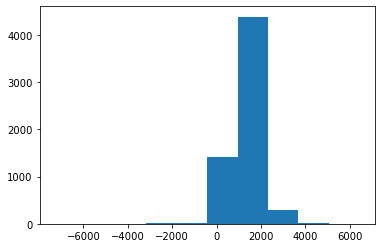

In [162]:
plt.hist(dfd.duration)

In [ ]:
dfd.to_csv("../data/petitioner_duration.csv", index= False)

## Getting the Words Said By the Petitioners and Justices in Each Case

For my analysis I want only the words said by the petioners or the justices, so Im going to use my custom function to make a dictionary that has this data. I searched long and hard for a way to scrape the lawyers and advocated for each side, but there was no way to do so for a large percentage of my data. While the petitioner always speaks first, the function is imperfect as it just takes the first lawyers words and the justice responses to those words. The petitioner could have another speaker that this function would not capture, but for the purposes of NLP we can still evualaute whether the words have any predictive power. 

In [104]:
#making the dictionary 
petitioner_words_dict = {}
for x in speaker_cleanText:
    try:
        petitioner_words_dict.update({x: src.get_petitioner_words(x, justices, case_lawyers_dict, speaker_cleanText)})
        #get_petitioner_words is a function which makes a list with the words said only by 
        #the petitioners or the justices in response
    except:
        #some of the cases do not have transcripts which breaks the function
        pass

In [29]:
len(petitioner_words_dict)

6005

In [30]:
justice_words_dict = {}
for x in speaker_cleanText:
    try:
        justice_words_dict.update({x: src.get_justice_words(x, justices, case_lawyers_dict, speaker_cleanText)})
        #this does the same but only for the justice words said in response t0 or to the petitioner 
    except:
        pass

In [ ]:
def get_petitioner_words (case, justices, caseldict, sct):
    
    

## Dictionary to DataFrame and cleaning up the column titles and value

In [58]:
dfj = pd.DataFrame.from_dict(justice_words_dict.items()) #turning both dicts into DFs 

In [59]:
df = pd.DataFrame.from_dict(petitioner_words_dict.items())

In [60]:
df.columns = ['case', 'text']
dfj.columns = ['case', 'text']

In [61]:
df[df.case =="353 US 373 (1957)"] #testing to make sure the rows are what I think they are

,case,text
45,353 US 373 (1957),"[[[['I', 'be', 'include', 'my', 'remark', 'wit..."


Getting rid of a bunch of punctuation

In [97]:
#remopving remanants of the nested list structure
df.text = df.text.apply(lambda x: str(x).replace('[','').replace(']', ''))
dfj.text = dfj.text.apply(lambda x: str(x).replace('[','').replace(']', ''))


In [98]:
#taking out commas
df.text = df.text.apply(lambda x: x.replace(",", ''))
dfj.text = dfj.text.apply(lambda x: x.replace(",", ''))

In [99]:
df.head()

,case,text
0,352us282,may it please the court this case be here on a...
1,353us586,mr chief justice if the court please when the ...
2,352us599,mr chief justice and associate justice of the ...
3,352us82,may it please the court mr williams this matte...
4,352us220,may it please the court mr plauche you may pro...


In [127]:
#removing the year from the citation as its not present in my other dataset
df.case = df.case.apply(lambda x: re.sub('(\d\d\d\d)', '', x))
dfj.case = dfj.case.apply(lambda x: re.sub('(\d\d\d\d)', '', x))


In [101]:
#lowercase
df.case = df.case.apply(lambda x: x.lower())
dfj.case = dfj.case.apply(lambda x: x.lower())

### Removing non ascii characters

These do not act like strings and are hard to merge on.

In [102]:
#My custom function for modifying the "case" colum to remove non ascii characters
df.case = df.case.apply(lambda x: src.remove_non_ascii_chars(x)) 
dfj.case = dfj.case.apply(lambda x: src.remove_non_ascii_chars(x))

In [103]:
df[df.case == '352us282']#this would not work if the function did not work

,case,text
0,352us282,may it please the court this case be here on a...


In [104]:
#doing the same with the text but with a slightly different function
df.text = df.text.apply(lambda x: src.remove_non_ascii_chars_t(x))
dfj.text = dfj.text.apply(lambda x: src.remove_non_ascii_chars_t(x))

In [105]:
#other clean up after changing to ascii
df.text = df.text.apply(lambda x: x.replace("'", "" ))
dfj.text = dfj.text.apply(lambda x: x.replace("'", "" ))

In [106]:
#checking my work 
df.head()

,case,text
0,352us282,may it please the court this case be here on a...
1,353us586,mr chief justice if the court please when the ...
2,352us599,mr chief justice and associate justice of the ...
3,352us82,may it please the court mr williams this matte...
4,352us220,may it please the court mr plauche you may pro...


In [107]:
#and checking on the justices 
dfj.head()

,case,text
0,352us282,that instruction i take it in effect import in...
1,353us586,may i at this point ask to be declare inaudibl...
2,352us599,well of course of course you may yes now mr mr...
3,352us82,mr williams that do not mean that it be only a...
4,352us220,mr plauche you may proceed deny the united sta...


## Importing CSV with Further Case Info and Target Variable

This is SCDB CSV which has all my categorical data including the target variable of whether or not the petitioner won.

In [108]:
#importing the CSV from the SCDB with cp1252 encoding 
df2 = pd.read_csv("../data/SCDB_2020_01_caseCentered_Citation.csv", encoding='cp1252')                 

In [109]:
df2.head()#checking it out

,caseId,docketId,caseIssuesId,voteId,dateDecision,decisionType,usCite,sctCite,ledCite,lexisCite,term,naturalCourt,chief,docket,caseName,...,voteUnclear,issue,issueArea,decisionDirection,decisionDirectionDissent,authorityDecision1,authorityDecision2,lawType,lawSupp,lawMinor,majOpinWriter,majOpinAssigner,splitVote,majVotes,minVotes
0,1946-001,1946-001-01,1946-001-01-01,1946-001-01-01-01,11/18/1946,1,329 U.S. 1,67 S. Ct. 6,91 L. Ed. 3,1946 U.S. LEXIS 1724,1946,1301,Vinson,24,HALLIBURTON OIL WELL CEMENTING CO. v. WALKER e...,...,0.0,80180.0,8.0,2.0,0.0,4.0,NaN,6.0,600.0,35 U.S.C. § 33,78.0,78.0,1,8,1
1,1946-002,1946-002-01,1946-002-01-01,1946-002-01-01-01,11/18/1946,1,329 U.S. 14,67 S. Ct. 13,91 L. Ed. 12,1946 U.S. LEXIS 1725,1946,1301,Vinson,12,CLEVELAND v. UNITED STATES,...,0.0,10500.0,1.0,1.0,0.0,4.0,NaN,6.0,600.0,18 U.S.C. § 398,81.0,87.0,1,6,3
2,1946-003,1946-003-01,1946-003-01-01,1946-003-01-01-01,11/18/1946,1,329 U.S. 29,67 S. Ct. 1,91 L. Ed. 22,1946 U.S. LEXIS 3037,1946,1301,Vinson,21,CHAMPLIN REFINING CO. v. UNITED STATES ET AL.,...,0.0,80250.0,8.0,2.0,0.0,1.0,NaN,2.0,207.0,NaN,84.0,78.0,1,5,4
3,1946-004,1946-004-01,1946-004-01-01,1946-004-01-01-01,11/25/1946,7,329 U.S. 40,67 S. Ct. 167,91 L. Ed. 29,1946 U.S. LEXIS 1696,1946,1301,Vinson,26,UNITED STATES v. ALCEA BAND OF TILLAMOOKS ET AL.,...,0.0,20150.0,2.0,2.0,0.0,4.0,NaN,6.0,600.0,49 Stat. 801,87.0,87.0,1,5,3
4,1946-005,1946-005-01,1946-005-01-01,1946-005-01-01-01,11/25/1946,1,329 U.S. 64,67 S. Ct. 154,91 L. Ed. 44,1946 U.S. LEXIS 2997,1946,1301,Vinson,50,"UNITED STATES v. HOWARD P. FOLEY CO., INC.",...,0.0,80060.0,8.0,2.0,0.0,7.0,NaN,NaN,NaN,NaN,78.0,87.0,1,6,3


## Merging with Text DF

In [110]:
#grabbing only the columns I want to explore in combination with thet text data
target_name_df = df2[['partyWinning', 'usCite', 'decisionDirection', 'majVotes']].copy()#grabbing just the columns I need

In [111]:
# changing column names
target_name_df.columns = ['target', 'case', 'lib_or_con', 'majVotes']

In [112]:
#removing punctiation
target_name_df['case'] = target_name_df['case'].apply(lambda x: str(x).replace('.', '').lower().replace(' ', ''))#removing punctation

In [113]:
target_name_df.head()

,target,case,lib_or_con,majVotes
0,1.0,329us1,2.0,8
1,0.0,329us14,1.0,6
2,0.0,329us29,2.0,5
3,0.0,329us40,2.0,5
4,1.0,329us64,2.0,6


In [114]:
# testing the case variable to make sure I can merge with the text data
target_name_df[target_name_df.case == '352us282' ]

,target,case,lib_or_con,majVotes
1129,1.0,352us282,2.0,6


### Merging with the Text Data

In [115]:
#merging on the case citation column
final_df = df.merge(target_name_df, on ='case') 
final_justice_df= dfj.merge(target_name_df, on ='case')

In [116]:
#filtering down to "close votes"
final_df = final_df[final_df.majVotes < 7] # narrowing down to "close votes"
final_justice_df = final_justice_df[final_justice_df.majVotes < 7]

In [117]:
final_df.head()

,case,text,target,lib_or_con,majVotes
0,352us282,may it please the court this case be here on a...,1.0,2.0,6
1,353us586,mr chief justice if the court please when the ...,1.0,2.0,4
5,352us249,if the court please you might wait just a mome...,0.0,2.0,5
9,354us147,mr chief justice if the court please this be a...,0.0,2.0,5
10,352us407,mr chief justice may it please the court this ...,1.0,1.0,6


In [118]:
final_df.target.value_counts()# checking to make sure there are enough of each class

1.0    1435
0.0    1022
Name: target, dtype: int64

In [119]:
final_df = final_df[final_df.target!= 2.0]# getting rid of the one close case wich had an undefined result
final_justice_df = final_justice_df[final_justice_df.target != 2.0]

In [120]:
final_df = final_df.dropna()#dropping nans that came with the categorical data 
final_justice_df = final_justice_df.dropna()

In [121]:
import math
#this was the most consistent way to turn floats into integers
final_df.target = final_df.target.apply(lambda x: math.trunc(x)) 
final_justice_df.target = final_justice_df.target.apply(lambda x: math.trunc(x))

In [122]:
final_df.target.value_counts() #checking to make sure it works

1    1435
0    1021
Name: target, dtype: int64

In [124]:
final_justice_df.target.value_counts()# theyre the same which is a good thing and makes sense

1    1435
0    1021
Name: target, dtype: int64

In [125]:
#have not kept up as much with the final justice df, lets see if we did all the steps
final_justice_df.head()

,case,text,target,lib_or_con,majVotes
0,352us282,that instruction i take it in effect import in...,1,2.0,6
1,353us586,may i at this point ask to be declare inaudibl...,1,2.0,4
5,352us249,you might wait just a moment until counsel get...,0,2.0,5
9,354us147,what be the second general what be the second ...,0,2.0,5
10,352us407,this be all before any evidence be take out co...,1,1.0,6


In [126]:
final_df.to_csv('../data/Final_Merge.csv', index = False)# exporting to a csv for EDA and modeling
final_justice_df.to_csv('../data/final_justice.csv', index = False)